In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt




In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe
print(raw_data.shape)

(4998, 141)


In [22]:

# Transforms images to a PyTorch Tensor
# tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
# dataset = datasets.MNIST(root = "./data",
#                          train = True,
#                          download = True,
#                          transform = tensor_transform)
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.values, dtype=torch.float32)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

class SpectralDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
    
    
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()
dataset = dataframe.iloc[:,:-1]

dataset = MyDataset(dataset)
loader = DataLoader(dataset, batch_size=2048, shuffle=True)




# THIS IS WRONG. can't easily convert from pandas dataframe to pytorch dataset

# DataLoader is used to load the dataset
# for training
# loader = torch.utils.data.DataLoader(dataset = dataset,
#                                      batch_size = 2048,
#                                      shuffle = True)


In [4]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
print(data.shape)
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

(4998, 140)


In [5]:
min_val = torch.min(torch.from_numpy(train_data))
max_val = torch.max(torch.from_numpy(train_data))

train_data = (torch.from_numpy(train_data) - min_val) / (max_val - min_val)
test_data = (torch.from_numpy(test_data) - min_val) / (max_val - min_val)

train_data = train_data.float()
test_data = test_data.float()

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

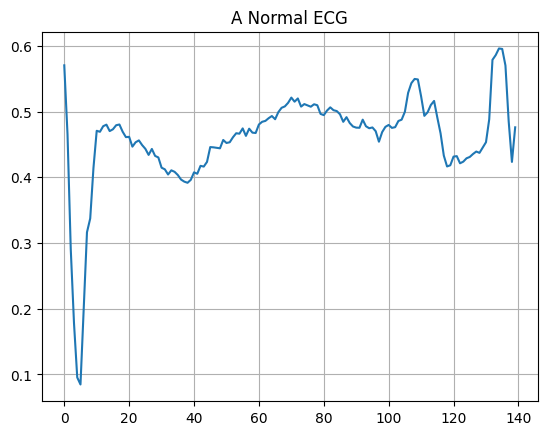

In [7]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

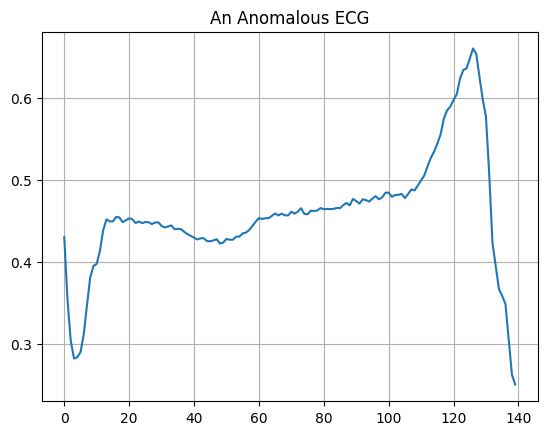

In [8]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [9]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 140 ==> 3
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(140, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            # torch.nn.ReLU(),
            # torch.nn.Linear(8, 3)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 3 ==> 140
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(3, 8),
            # torch.nn.ReLU(),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 140),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
# loss_function = torch.nn.MSELoss()
# Validation using MAE Loss function
loss_function = torch.nn.L1Loss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [11]:
# epochs = 100
# outputs = []
# losses = []
# for epoch in range(epochs):
#     for image in loader:

#       # Reshaping the image to (-1, 784)
#       # image = image.reshape(-1, 28*28)
#       # image = image.to(device)

#       # Output of Autoencoder
#       reconstructed = model(image)

#       # Calculating the loss function
#       loss = loss_function(reconstructed, image)

#       # The gradients are set to zero,
#       # the gradient is computed and stored.
#       # .step() performs parameter update
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       # Storing the losses in a list for plotting
#       losses.append(loss.detach().numpy())
#     outputs.append((epochs, image, reconstructed))

# # Defining the Plot Style
# plt.style.use('fivethirtyeight')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')

# # Plotting the last 100 values
# plt.plot(losses[-100:])

In [12]:
# class AnomalyDetector(Model):
#   def __init__(self):
#     super(AnomalyDetector, self).__init__()
#     self.encoder = tf.keras.Sequential([
#       layers.Dense(32, activation="relu"),
#       layers.Dense(16, activation="relu"),
#       layers.Dense(8, activation="relu")])

#     self.decoder = tf.keras.Sequential([
#       layers.Dense(16, activation="relu"),
#       layers.Dense(32, activation="relu"),
#       layers.Dense(140, activation="sigmoid")])

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# autoencoder = AnomalyDetector()

# autoencoder.compile(optimizer='adam', loss='mae')
# torch_tensor = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32)

# normal_train_data = tf.convert_to_tensor(torch_tensor.numpy(), dtype=tf.float32)

# history = autoencoder.fit(normal_train_data, normal_train_data,
#           epochs=20,
#           batch_size=2048,
#           validation_data=(test_data, test_data),
#           shuffle=True)


In [13]:
# Training loop


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512)

epochs = 200
history_loss_train = []
history_loss_val = []
for epoch in range(epochs):
    model.train()
    for inputs in train_loader:
        # inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for inputs in test_loader:
            # inputs = inputs.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, inputs)
    history_loss_train.append(loss.item())
    history_loss_val.append(val_loss.item())
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}')



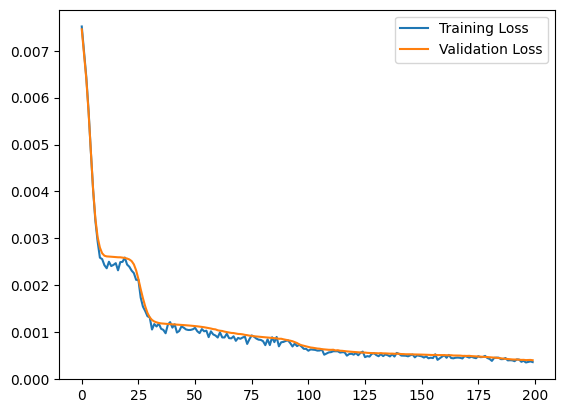

In [14]:
plt.plot(history_loss_train, label="Training Loss")
plt.plot(history_loss_val, label="Validation Loss")
plt.legend()


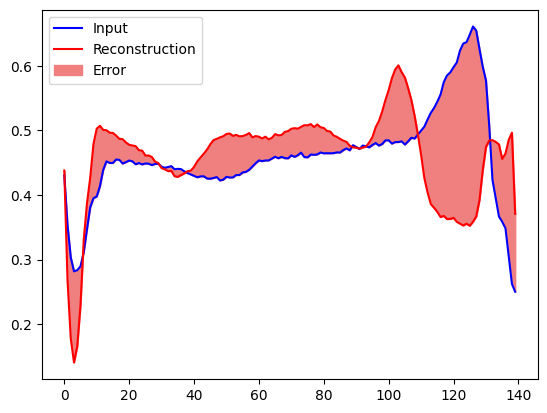

In [15]:
encoded_data = model.encoder(normal_test_data).detach().numpy()
# decoded_data = model.decoder(encoded_data).detach().numpy()
decoded_data = model.decoder(torch.from_numpy(encoded_data)).detach()
# plt.plot(normal_test_data[0], 'b')
plt.plot(anomalous_train_data[0], 'b')


plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_train_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


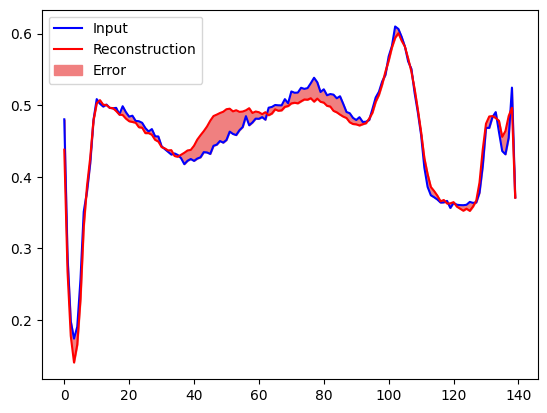

In [16]:
encoded_data = model.encoder(normal_test_data).detach().numpy()
# decoded_data = model.decoder(encoded_data).detach().numpy()
decoded_data = model.decoder(torch.from_numpy(encoded_data)).detach()
plt.plot(normal_test_data[0], 'b')
# plt.plot(anomalous_train_data[0], 'b')


plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [19]:
import os
import cv2
def load_hsi(file_name):
    # load hyperspectral image
    _, extension = os.path.splitext(file_name)

    if extension == '.tiff':
        #below is a way to load hyperspectral images that are tiff files
        mylist = []
        loaded,mylist = cv2.imreadmulti(mats = mylist, filename = file_name, flags = cv2.IMREAD_ANYCOLOR )
        cube=np.array(mylist)
        cube = cube[:, :, :]
    else :
        print("Error: file type not supported")
        return
    return cube

hyperImage = load_hsi('../../HyperImages/img1.tiff')


In [20]:
print(hyperImage.shape)
hyper_result = np.transpose(hyperImage, (2, 1, 0))
print(hyper_result.shape)
#hyper_2d = hyper_result.reshape(hyper_result[0] * hyper_result[1], hyper_result[2])
new_shape_first_dim = hyper_result.shape[0] * hyper_result.shape[1]
hyper_2d = hyper_result.reshape((new_shape_first_dim, hyper_result.shape[2]))
print(hyper_2d.shape)

(164, 1886, 1886)
(1886, 1886, 164)
(3556996, 164)


In [30]:
spectral_dataset = SpectralDataset(hyper_2d)
spectral_loader = DataLoader(spectral_dataset, batch_size=2048, shuffle=True)

spectral_train_data, spectral_test_data = train_test_split(
    spectral_dataset,  test_size=0.2, random_state=21
)

min_val = torch.min(torch.from_numpy(hyper_2d))
max_val = torch.max(torch.from_numpy(hyper_2d))

# spectral_train_data = ((torch.from_numpy(spectral_train_data) - min_val) / (max_val - min_val)).float()
# spectral_test_data = ((torch.from_numpy(spectral_test_data) - min_val) / (max_val - min_val)).float()

# Normalize each Tensor in the list
spectral_train_data = [(data - min_val) / (max_val - min_val) for data in spectral_train_data]
spectral_test_data = [(data - min_val) / (max_val - min_val) for data in spectral_test_data]

# Convert the list of Tensors to a single Tensor
spectral_train_data = torch.stack(spectral_train_data).float()
spectral_test_data = torch.stack(spectral_test_data).float()




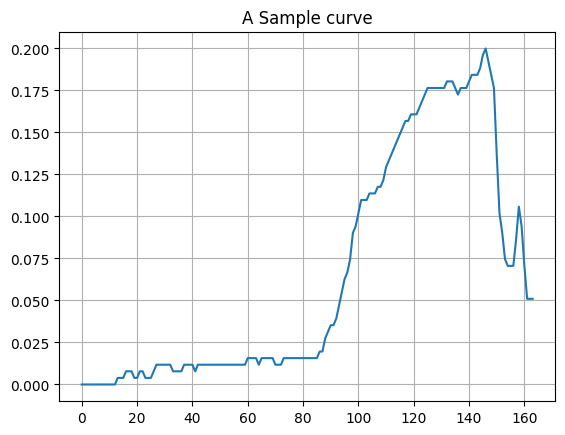

In [31]:
plt.grid()
plt.plot(np.arange(hyper_2d.shape[1]), spectral_train_data[0])
plt.title("A Sample curve")
plt.show()

In [37]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class spectral_AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 140 ==> 3
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(hyper_2d.shape[1], 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 3)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 3 ==> 140
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, hyper_2d.shape[1]),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [68]:
spectral_model = spectral_AE()


train_loader = DataLoader(spectral_train_data, batch_size=16384, shuffle=True)
test_loader = DataLoader(spectral_test_data, batch_size=8192)






In [69]:
loss_function = torch.nn.L1Loss()
criterion = torch.nn.MSELoss()
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print (device)
spectral_model = spectral_model.to(device)
optimizer = torch.optim.Adam(spectral_model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)

epochs = 200
history_loss_train = []
history_loss_val = []
for epoch in range(epochs):
    spectral_model.train()
    for inputs in train_loader:
        inputs = inputs.to(device)
        outputs = spectral_model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    spectral_model.eval()
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = spectral_model(inputs)
            val_loss = criterion(outputs, inputs)
    history_loss_train.append(loss.item())
    history_loss_val.append(val_loss.item())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

Epoch 1/200, Loss: 0.020627498626708984, Validation Loss: 0.020157093182206154
Epoch 2/200, Loss: 0.0026859352365136147, Validation Loss: 0.002636608202010393
Epoch 3/200, Loss: 0.002202243311330676, Validation Loss: 0.002132619498297572
Epoch 4/200, Loss: 0.002211973536759615, Validation Loss: 0.002141631906852126
Epoch 5/200, Loss: 0.0019446403020992875, Validation Loss: 0.0018935644766315818
Epoch 6/200, Loss: 0.001832864829339087, Validation Loss: 0.0018065860494971275
Epoch 7/200, Loss: 0.0017852707533165812, Validation Loss: 0.0017364723607897758
Epoch 8/200, Loss: 0.001779650105163455, Validation Loss: 0.001706080511212349
Epoch 9/200, Loss: 0.001786250271834433, Validation Loss: 0.0016830249223858118
Epoch 10/200, Loss: 0.0016658409731462598, Validation Loss: 0.0016267824685201049
Epoch 11/200, Loss: 0.0016435608267784119, Validation Loss: 0.0016041201306506991
Epoch 12/200, Loss: 0.0016367738135159016, Validation Loss: 0.0015908051282167435
Epoch 13/200, Loss: 0.00166251452174

KeyboardInterrupt: 

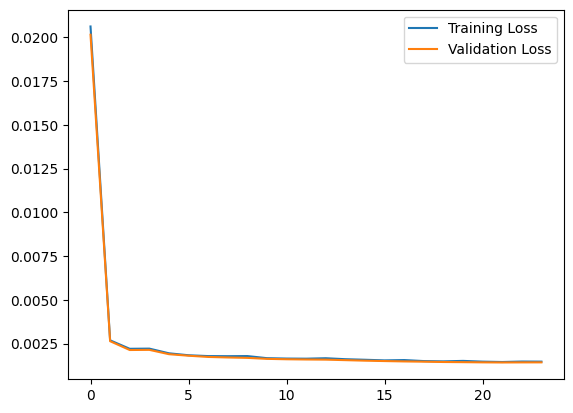

In [70]:
plt.plot(history_loss_train, label="Training Loss")
plt.plot(history_loss_val, label="Validation Loss")
plt.legend()


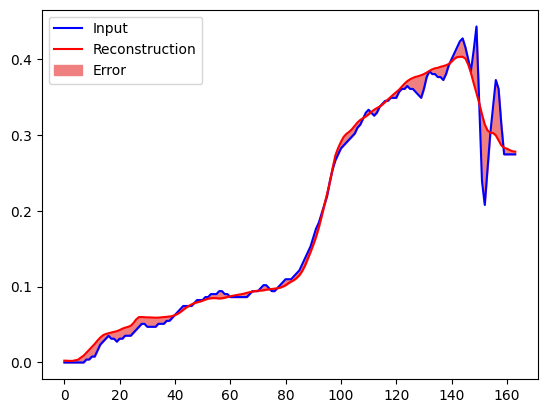

In [71]:
spectral_test_data = spectral_test_data.to(device)

encoded_data = spectral_model.encoder(spectral_test_data).detach().cpu().numpy()
decoded_data = spectral_model.decoder(torch.from_numpy(encoded_data).to(device)).detach().cpu().numpy()

# encoded_data = spectral_model.encoder(spectral_test_data).detach().numpy()
# decoded_data = model.decoder(encoded_data).detach().numpy()
# decoded_data = spectral_model.decoder(torch.from_numpy(encoded_data)).detach()
# plt.plot(normal_test_data[0], 'b')

spectral_test_data_np = spectral_test_data.cpu().numpy()

plt.plot(spectral_test_data_np[0], 'b')


plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(hyper_2d.shape[1]), decoded_data[0], spectral_test_data_np[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

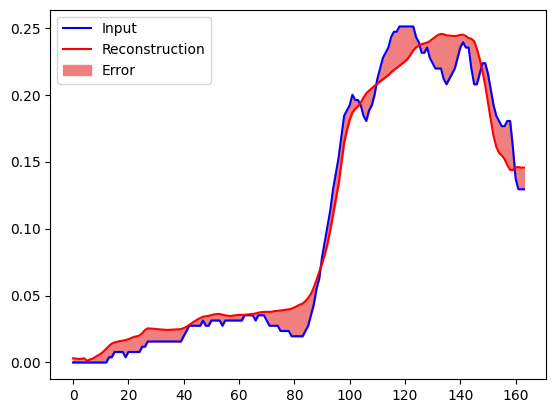

In [72]:
test_index=1000
plt.plot(spectral_test_data_np[test_index], 'b')


plt.plot(decoded_data[test_index], 'r')
plt.fill_between(np.arange(hyper_2d.shape[1]), decoded_data[test_index], spectral_test_data_np[test_index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()